In [42]:
from nilearn import plotting, image, masking
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker

In [16]:
!PATH=/home/06028/tbweng/corral/anibal/afni:$PATH R --slave --no-restore --file=/home/06028/tbweng/corral/anibal/afni/3dLME.R --gui X11 --args \
        -prefix lme.nii.gz -jobs 20 -cio \
        -model "SSRT+run" \
        -qVars "SSRT,run" \
        -ranEff "~1" \
        -dataTable @./table.txt
    

Read 2884 items
Loading required package: nlme
Package nlme loaded successfully!

Loading required package: phia
Loading required package: car
Loading required package: carData
Package phia loaded successfully!


++++++++++++++++++++++++++++++++++++++++++++++++++++
***** Summary information of data structure *****
37 subjects :  1 10 11 12 13 14 16 17 18 19 2 20 21 23 24 25 26 27 28 29 3 31 32 33 34 35 36 37 38 39 4 40 42 43 44 46 6 
720 response values
720 centered values for numeric variable run : -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 -0.4861111 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.5138889 0.513

In [18]:
!singularity exec /home/06028/tbweng/corral/singularity_images/cnc_afni_latest.sif 3dFDR -prefix lme-fdr.nii.gz -input lme.nii.gz

mkdir: cannot create directory '/home/06028/tbweng/R': File exists
++ 3dFDR: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]
++ Authored by: B. Douglas Ward
++ WARNING: file /home/06028/tbweng/.afni.log is now 134108609 (134 million [mega]) bytes long!

++ The 'new' method of FDR calculation is on by default; in particular:
 + * Voxel p-values of exactly 1 (e.g., from t=0 or F=0 or correlation=0)
 +   are ignored by default; in the old mode of operation, they were
 +   included in the count which goes into the FDR algorithm.  The old
 +   process tends to increase the q-values and so decrease the z-scores.
 + * If you wish to do the FDR conversion using the old mode, use '-old'
 +   on the command line.  For more information, use '3dFDR -help'.
 + * If you don't want to see this message again, use the '-new' option.
++ RWCox - 18 Jan 2008

Reading input dataset: lme.nii.gz 
** AFNI converts NIFTI_datatype=4 (INT16) in file lme.nii.gz to FLOAT32
     Warnings of this type will be muted

In [45]:
lme = nb.load(f'lme-fdr.nii.gz')
lme = nb.Nifti1Image(np.squeeze(lme.get_fdata()), lme.affine)

In [37]:
range(lme.shape[-1])

range(0, 3)

In [40]:
!singularity exec /home/06028/tbweng/corral/singularity_images/fcpindi_c-pac_latest-1.6.0.sif fslmaths func_to_standard_group_4d_mean -bin func_to_standard_group_4d_mean_bin

In [43]:
nifti_masker = NiftiMasker(
    mask_img='./func_to_standard_group_4d_mean_bin.nii.gz',
    smoothing_fwhm=4
)

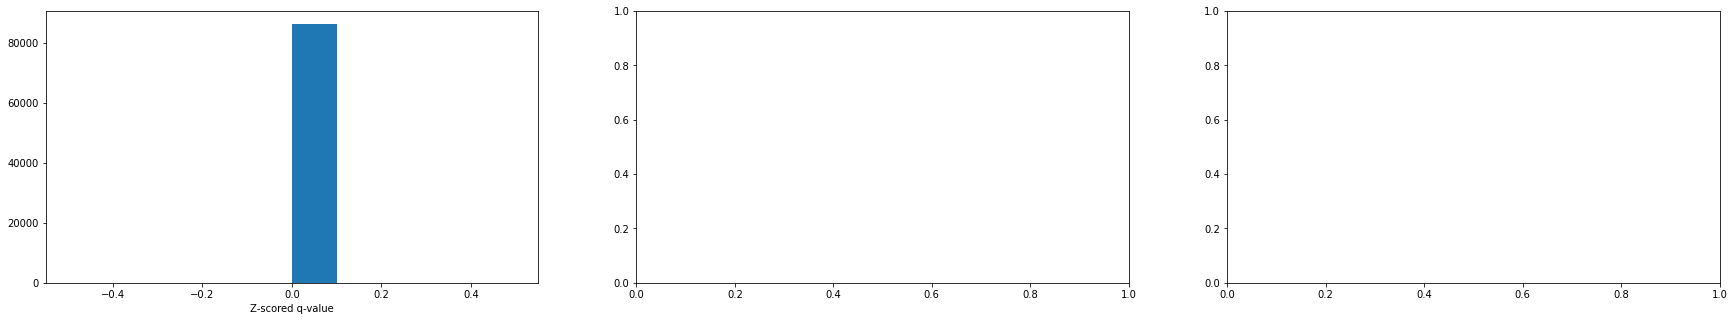

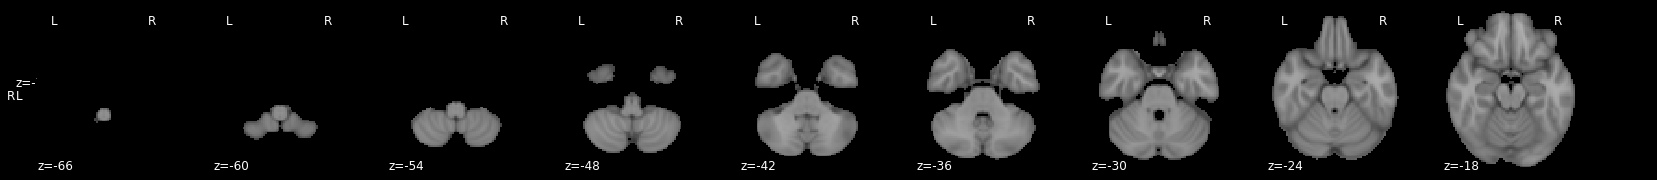

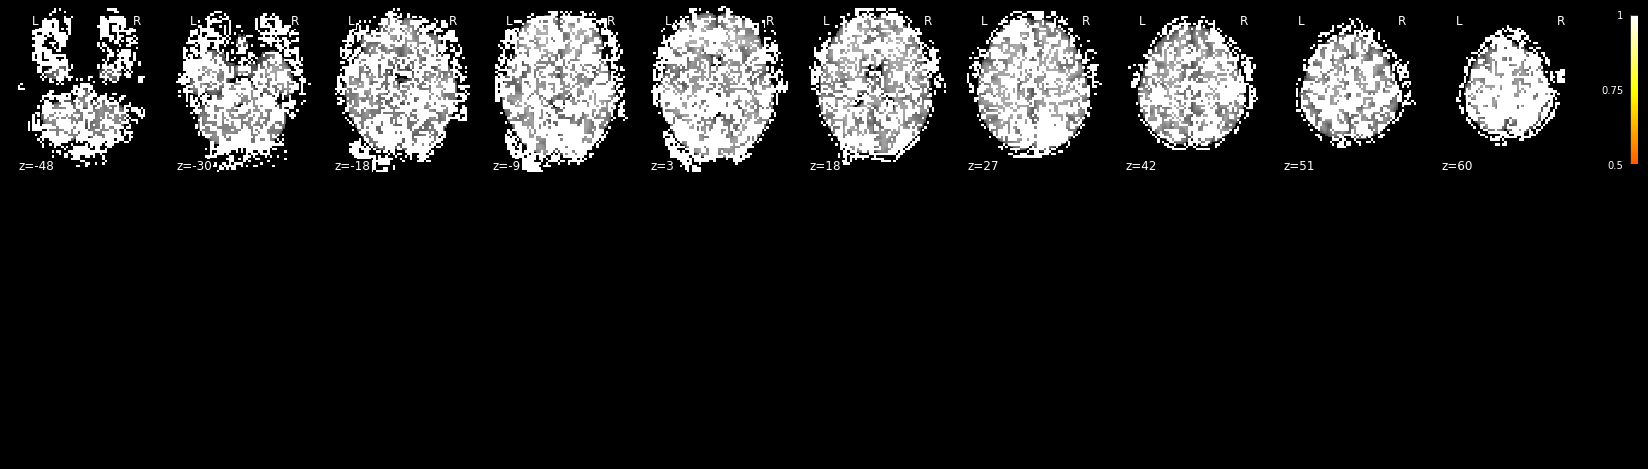

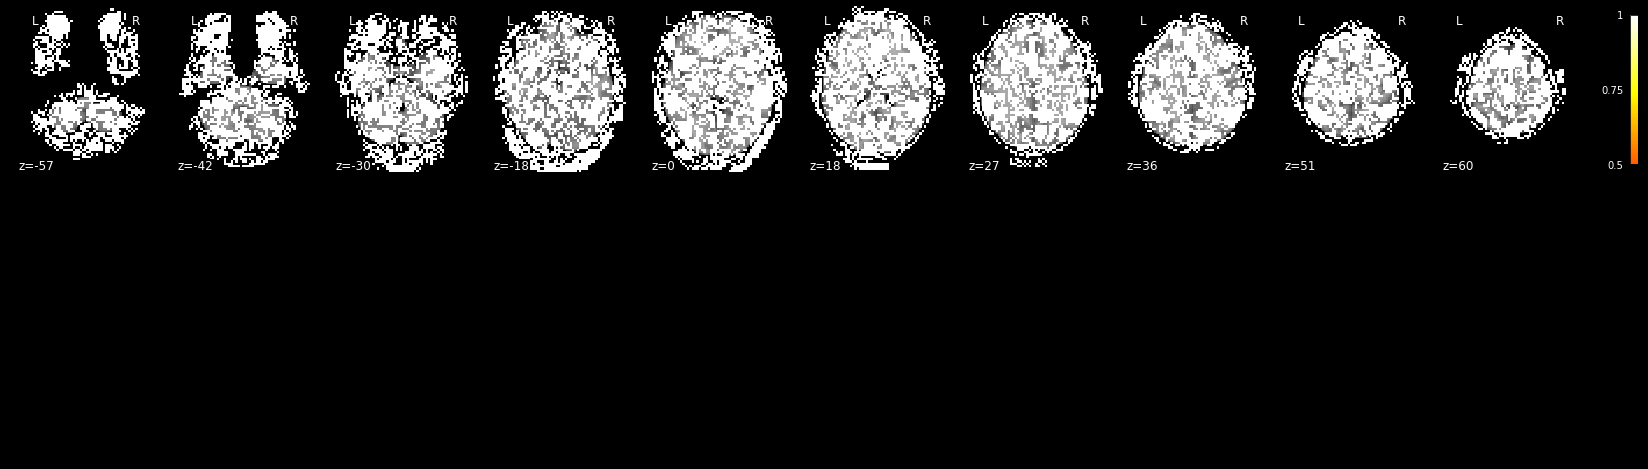

In [53]:
fig, axs = plt.subplots(1, lme.shape[-1], figsize=(30, 5))
for i in range(lme.shape[-1]):
    axs[i].hist(nifti_masker.fit_transform(image.index_img(lme, i)).flatten())
#         axs[i].set_title(labels[i])
    axs[i].set_xlabel('Z-scored q-value')
    plt.show()
    
mean_func = nb.load(f'func_to_standard_group_4d_mean_bin.nii.gz')

for i in range(lme.shape[-1]):
    lme_image = image.index_img(lme, i).get_fdata()
#     lme_mask = (lme_image < 2.4).astype(bool)
#     lme_image[lme_mask] = 0.0
#     lme_image[~lme_mask] = 1.0
    lme_image = nb.Nifti1Image(lme_image, affine=lme.affine)

    if np.any(lme_image.get_fdata() > 0):
        nifti_masker = NiftiMasker(mask_img=lme_image)
        lme_image = nifti_masker.inverse_transform(nifti_masker.fit_transform(mean_func))

            
    plotting.plot_stat_map(
        lme_image,
        display_mode="z",
        cut_coords=10,
        black_bg=True,

    )
    plt.show();
